# CS 6120: Natural Language Processing
## Final Project: Music Genre Classification
## Authors: Bharat Chawla and Himaja R. Ginkala

In [1]:
# importing libraries
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import keras
from keras.layers import Dense, Flatten, LSTM, Layer, MaxPooling1D, Dropout, Activation, Attention
from keras.layers import Embedding
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /home/chawla.bh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data Preparation

In [2]:
# load data from CSV file
df_english_cleaned = pd.read_csv('english_cleaned.csv')

#### Vocabulary

In [3]:
# load vocabulary from file
with open('vocabulary.txt', "r") as f:
    vocabulary = f.readlines()

print("Vocabulary Size: ", len(vocabulary))

# replace new line characters
vocabulary = list(map(lambda s: s.strip(), vocabulary))

Vocabulary Size:  186126


In [4]:
# create word to id dictionary
word_to_id = {}
for i, word in enumerate(vocabulary):
  word_to_id[word] = i + 1

#### Glove Embeddings

In [5]:
# open glove embeddings file
glove_file = open('glove.6B.100d.txt')

glove_embeddings = {}
for line in glove_file:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype = 'float32')
  glove_embeddings[word] = coefs

glove_file.close()

all_glove_words = list(glove_embeddings.keys())
print("Found %s word vectors." % len(glove_embeddings))

Found 400000 word vectors.


#### Embedding Matrix

In [6]:
embedding_matrix = np.zeros((len(vocabulary), 100))

for word, i in word_to_id.items():
  embedding_vector = glove_embeddings.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

(186126, 100)


In [7]:
# get only data with cleaned lyrics
df_english = df_english_cleaned[df_english_cleaned['Cleaned_Lyric'].notna()]

#### Genre Separation

In [8]:
# convert multi-valued column to single value
for i, row in df_english.iterrows():
  if ";" in str(df_english.at[i, 'Genres']):
    genres = df_english.at[i, 'Genres'].split("; ")
    df_english.at[i, 'Genres'] = genres[0]

#rename column
df_english.rename(columns = {'Genres':'Genre'}, inplace = True)
df_english['Genre'] = df_english['Genre'].replace('Pop/Rock', 'Pop-Rock')
df_english

,Artist,SName,Genre,Lyric,Popularity,Language,Cleaned_Lyric
0,Ivete Sangalo,Careless Whisper,Pop,I feel so unsure\nAs I take your hand and lead...,4.4,en,feel unsure take hand lead dance floor music d...
1,Ivete Sangalo,Could You Be Loved / Citação Musical do Rap: S...,Pop,"Don't let them fool, ya\nOr even try to school...",4.4,en,let fool ya even try school ya oh got mind go ...
2,Ivete Sangalo,Cruisin' (Part. Saulo),Pop,"Baby, let's cruise, away from here\nDon't be c...",4.4,en,baby let cruise away confused way clear want g...
3,Ivete Sangalo,Easy,Pop,"Know it sounds funny\nBut, I just can't stand ...",4.4,en,know sounds funny stand pain girl leaving tomo...
4,Ivete Sangalo,For Your Babies (The Voice cover),Pop,You've got that look again\nThe one I hoped I ...,4.4,en,got look one hoped lad face beaming smile got ...
...,...,...,...,...,...,...,...
191382,Johnny Clegg,The Waiting,World Music,Chorus\nHere we stand waiting on the plain\nDa...,0.0,en,chorus stand waiting plain darkness taken last...
191383,Johnny Clegg,Too Early For The Sky,World Music,I nearly disappeared into the mouth of a croco...,0.0,en,nearly disappeared mouth crocodile nearly touc...
191384,Johnny Clegg,Warsaw 1943 (I Never Betrayed The Revolution),World Music,"Amambuka, amambuka azothengisa izwe lakithi, i...",0.0,en,amambuka amambuka azothengisa izwe lakithi izw...
191385,Johnny Clegg,When The System Has Fallen,World Music,Sweat in the heat for days on end\nwaiting for...,0.0,en,sweat heat days end waiting come hear words sp...


In [9]:
# get genre count
genre_counts = df_english['Genre'].value_counts()
print("Number of English Genres: ", genre_counts)

# get genre names
genre_names = df_english['Genre'].value_counts().index.tolist()

Number of English Genres:  Rock             25177
Pop              13759
Heavy Metal      13496
Indie            12998
Rap               9589
                 ...  
Electro Swing        6
Jovem Guarda         6
Forró                3
Lo-fi                1
Regional             1
Name: Genre, Length: 73, dtype: int64


In [10]:
# create dataframe of only top 10 genres in English
top_10_genres = genre_names[0:10]
df_english_top_10_genres = df_english[df_english['Genre'].isin(top_10_genres)]

# create dataframe of only top 5 genres in English
top_5_genres = genre_names[0:5]
df_english_top_5_genres = df_english[df_english['Genre'].isin(top_5_genres)]
df_english_top_5_genres

,Artist,SName,Genre,Lyric,Popularity,Language,Cleaned_Lyric
0,Ivete Sangalo,Careless Whisper,Pop,I feel so unsure\nAs I take your hand and lead...,4.4,en,feel unsure take hand lead dance floor music d...
1,Ivete Sangalo,Could You Be Loved / Citação Musical do Rap: S...,Pop,"Don't let them fool, ya\nOr even try to school...",4.4,en,let fool ya even try school ya oh got mind go ...
2,Ivete Sangalo,Cruisin' (Part. Saulo),Pop,"Baby, let's cruise, away from here\nDon't be c...",4.4,en,baby let cruise away confused way clear want g...
3,Ivete Sangalo,Easy,Pop,"Know it sounds funny\nBut, I just can't stand ...",4.4,en,know sounds funny stand pain girl leaving tomo...
4,Ivete Sangalo,For Your Babies (The Voice cover),Pop,You've got that look again\nThe one I hoped I ...,4.4,en,got look one hoped lad face beaming smile got ...
...,...,...,...,...,...,...,...
181874,The Panic Channel,Outsider,Rock,I'm silent\nin the rolling wake\nof lucky and ...,0.0,en,silent rolling wake lucky adored ugly blur sid...
181875,The Panic Channel,Said You'd Be,Rock,smile and pose\nshaking hands and stealing vot...,0.0,en,smile pose shaking hands stealing votes agree ...
181876,The Panic Channel,She Won't Last,Rock,she's waiting to fall apart\nblind to how bad ...,0.0,en,waiting fall apart blind bad things know last ...
181877,The Panic Channel,Teahouse Of The Spirits,Rock,special guest will you come tonight\nbrief vis...,0.0,en,special guest come tonight brief visit side pa...


In [11]:
# reset indices
df_english_top_5_genres = df_english_top_5_genres.reset_index(drop = True)
df_english_top_5_genres

,Artist,SName,Genre,Lyric,Popularity,Language,Cleaned_Lyric
0,Ivete Sangalo,Careless Whisper,Pop,I feel so unsure\nAs I take your hand and lead...,4.4,en,feel unsure take hand lead dance floor music d...
1,Ivete Sangalo,Could You Be Loved / Citação Musical do Rap: S...,Pop,"Don't let them fool, ya\nOr even try to school...",4.4,en,let fool ya even try school ya oh got mind go ...
2,Ivete Sangalo,Cruisin' (Part. Saulo),Pop,"Baby, let's cruise, away from here\nDon't be c...",4.4,en,baby let cruise away confused way clear want g...
3,Ivete Sangalo,Easy,Pop,"Know it sounds funny\nBut, I just can't stand ...",4.4,en,know sounds funny stand pain girl leaving tomo...
4,Ivete Sangalo,For Your Babies (The Voice cover),Pop,You've got that look again\nThe one I hoped I ...,4.4,en,got look one hoped lad face beaming smile got ...
...,...,...,...,...,...,...,...
75014,The Panic Channel,Outsider,Rock,I'm silent\nin the rolling wake\nof lucky and ...,0.0,en,silent rolling wake lucky adored ugly blur sid...
75015,The Panic Channel,Said You'd Be,Rock,smile and pose\nshaking hands and stealing vot...,0.0,en,smile pose shaking hands stealing votes agree ...
75016,The Panic Channel,She Won't Last,Rock,she's waiting to fall apart\nblind to how bad ...,0.0,en,waiting fall apart blind bad things know last ...
75017,The Panic Channel,Teahouse Of The Spirits,Rock,special guest will you come tonight\nbrief vis...,0.0,en,special guest come tonight brief visit side pa...


#### Label Creation

In [12]:
# create labels
genre_labels = []
for genre in df_english_top_10_genres['Genre'].tolist():
  genre_labels.append(top_10_genres.index(genre))

print("Length of Labels List: ", len(genre_labels))

Length of Labels List:  110690


In [13]:
df_english_top_10_genres['Label'] = genre_labels
print(df_english_top_10_genres['Label'].value_counts())

0    25177
1    13759
2    13496
3    12998
4     9589
5     9019
6     8411
7     7377
8     5555
9     5309
Name: Label, dtype: int64


#### Balancing Dataset

In [14]:
# create a balanced dataset starting with top genre
df_balanced = df_english_top_10_genres[df_english_top_10_genres.Genre == top_10_genres[0]].sample(2000)

# get n random rows from each of the other top genres
for genre in top_10_genres[1:]:
  df_genre = df_english_top_10_genres[df_english_top_10_genres.Genre == genre].sample(2000)
  df_balanced = pd.concat([df_balanced, df_genre], ignore_index = True)

# ensure dataset is balanced
df_balanced['Genre'].value_counts()

R&B                 2000
Country             2000
Rock Alternativo    2000
Hip Hop             2000
Pop                 2000
Rap                 2000
Indie               2000
Rock                2000
Pop-Rock            2000
Heavy Metal         2000
Name: Genre, dtype: int64

In [15]:
# # get n random rows from each of the 5 top genre
# df_rock = df_english_top_5_genres[df_english_top_5_genres.Genre == "Rock"].sample(4000)
# df_pop = df_english_top_5_genres[df_english_top_5_genres.Genre == "Pop"].sample(4000)
# df_heavy_metal = df_english_top_5_genres[df_english_top_5_genres.Genre == "Heavy Metal"].sample(4000)
# df_indie = df_english_top_5_genres[df_english_top_5_genres.Genre == "Indie"].sample(4000)
# df_rap = df_english_top_5_genres[df_english_top_5_genres.Genre == "Rap"].sample(4000)

In [16]:
# df_balanced = pd.concat([df_rock, df_pop, df_heavy_metal, df_indie, df_rap], ignore_index = True)

# ensure dataset is balanced
# df_balanced['Genre'].value_counts()

#### Tokenization and Encoding

In [17]:
lyrics = df_balanced['Cleaned_Lyric'].tolist()

tokens = []
for lyric in lyrics:
  try:
    words = word_tokenize(lyric)
  except:
    print(lyric)

  tokens.append(words)

print("Length of Tokens List: ", len(tokens))

Length of Tokens List:  20000


In [18]:
encoded_tokens = []

# for every lyric
for line in tokens:
  encoded_line = []

  # for every word in lyric
  for word in line:
    # set to id value
    encoded_line.append(word_to_id.get(word))

  encoded_tokens.append(encoded_line)

print("Length of Encoded Tokens: ", len(encoded_tokens))

Length of Encoded Tokens:  20000


#### Padding

In [19]:
# get max length in list
max_length = len(max(encoded_tokens, key = len))
# pad training data
X = pad_sequences(encoded_tokens, maxlen = max_length)

#### Data Split

In [20]:
# convert to numpy arrays
X = np.array(X)
y = np.array(df_balanced['Label'].tolist())

# one hot encode labels
y = OneHotEncoder().fit_transform(y.reshape(-1, 1)).toarray()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state = 42,
    test_size = 0.3,
    shuffle = True)

### Global Variables

In [22]:
EPOCHS = 15
DROPOUT = 0.2
LEARNING_RATE = 0.003
BATCH_SIZE = 100

VOCAB_SIZE = len(vocabulary)
OUTPUT_SIZE = 10
N_LAYERS = 2
HIDDEN_DIM = 128
EMBEDDING_DIM = 100

### Model 1: Removing Global Average Pooling

#### Model Creation

In [23]:
def build_model_1(X):

  # set input layer
  input_layer = tf.keras.Input((X.shape[1],))

  # add embedding layer
  m = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights = [embedding_matrix])(input_layer)

  # add LSTM layer
  m = tf.keras.layers.LSTM(HIDDEN_DIM, return_sequences = False)(m)

  # add attention layer
  m = tf.keras.layers.Attention()([m, m])

  # add dropout layer
  m = tf.keras.layers.Dropout(DROPOUT)(m)

  # add linear layer
  m = tf.keras.layers.Dense(OUTPUT_SIZE, activation='softmax')(m)

  # build model
  model = tf.keras.models.Model(inputs = input_layer, outputs = m)

  # compile model
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['AUC', 'Precision', 'Accuracy', 'Recall'])

  return model

In [24]:
model_1 = build_model_1(X_train)
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2115)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 2115, 100)            1861260   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 lstm (LSTM)                 (None, 128)                  117248    ['embedding[0][0]']           
                                                                                                  
 attention (Attention)       (None, 128)                  0         ['lstm[0][0]',            

#### Model Execution

In [25]:
history_1 = model_1.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = 0.2)

Epoch 1/15
112/112 [==============================] - 206s 2s/step - loss: 2.2649 - auc: 0.5830 - precision: 0.0000e+00 - Accuracy: 0.1354 - recall: 0.0000e+00 - val_loss: 2.2587 - val_auc: 0.6023 - val_precision: 0.0000e+00 - val_Accuracy: 0.1618 - val_recall: 0.0000e+00
Epoch 2/15
112/112 [==============================] - 202s 2s/step - loss: 2.1736 - auc: 0.6454 - precision: 0.4333 - Accuracy: 0.1710 - recall: 0.0046 - val_loss: 2.0788 - val_auc: 0.6859 - val_precision: 0.7059 - val_Accuracy: 0.2036 - val_recall: 0.0043
Epoch 3/15
112/112 [==============================] - 202s 2s/step - loss: 2.1084 - auc: 0.6786 - precision: 0.4981 - Accuracy: 0.1993 - recall: 0.0230 - val_loss: 2.0574 - val_auc: 0.7067 - val_precision: 0.3433 - val_Accuracy: 0.2104 - val_recall: 0.0082
Epoch 4/15
112/112 [==============================] - 202s 2s/step - loss: 1.9659 - auc: 0.7406 - precision: 0.5873 - Accuracy: 0.2444 - recall: 0.0379 - val_loss: 1.9339 - val_auc: 0.7545 - val_precision: 0.6080 

#### Predictions and Results

In [26]:
y_pred_1 = model_1.predict(X_test)

188/188 [==============================] - 65s 341ms/step


In [27]:
print("y_test: ", y_test)

y_test:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [28]:
print("y_pred_1: ", y_pred_1)

y_pred_1:  [[1.84475943e-01 2.02355981e-01 3.93034238e-03 ... 1.58638656e-01
  2.64508892e-02 4.39025089e-02]
 [4.09240508e-03 1.05279781e-01 2.13518715e-03 ... 3.62551794e-03
  3.35655455e-03 5.10680377e-01]
 [1.80737596e-04 2.06223759e-03 7.40608375e-04 ... 1.95334960e-05
  2.34375708e-04 2.65906565e-02]
 ...
 [1.48445396e-02 7.18413949e-01 1.54314516e-03 ... 1.17505286e-02
  5.06219408e-03 1.09161675e-01]
 [3.95333245e-02 5.33417881e-01 2.72707548e-03 ... 1.54783875e-02
  2.60592122e-02 1.39090911e-01]
 [3.12012126e-04 2.38999515e-03 7.53837638e-04 ... 3.53936957e-05
  2.46332202e-04 4.00980711e-02]]


In [29]:
loss_1_train = history_1.history['loss']
loss_1_val = history_1.history['val_loss']

auc_1_train = history_1.history['auc']
auc_1_val = history_1.history['val_auc']

recall_1_train = history_1.history['recall']
recall_1_val = history_1.history['val_recall']

precision_1_train = history_1.history['precision']
precision_1_val = history_1.history['val_precision']

accuracy_1_train = history_1.history['Accuracy']
accuracy_1_val = history_1.history['val_Accuracy']

### Model 2: Removing Attention and Global Average Pooling

#### Model Creation

In [30]:
def build_model_2(X):

  # set input layer
  input_layer = tf.keras.Input((X.shape[1],))

  # add embedding layer
  m = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix])(input_layer)

  # add LSTM layer
  m = tf.keras.layers.LSTM(HIDDEN_DIM, return_sequences=False)(m)

  # add dropout layer
  m = tf.keras.layers.Dropout(DROPOUT)(m)

  # add linear layer
  m = tf.keras.layers.Dense(OUTPUT_SIZE, activation='softmax')(m)

  # build model
  model = tf.keras.models.Model(inputs = input_layer, outputs = m)

  # compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC', 'Precision', 'Accuracy', 'Recall'])

  return model

In [31]:
model_2 = build_model_2(X_train)
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2115)]            0         
                                                                 
 embedding_1 (Embedding)     (None, 2115, 100)         18612600  
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 18731138 (71.45 MB)
Trainable params: 18731138 (71.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Model Execution

In [32]:
history_2 = model_2.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = 0.2)

Epoch 1/15
112/112 [==============================] - 204s 2s/step - loss: 2.1826 - auc: 0.6414 - precision: 0.5489 - Accuracy: 0.1823 - recall: 0.0090 - val_loss: 2.1089 - val_auc: 0.6803 - val_precision: 0.7455 - val_Accuracy: 0.2200 - val_recall: 0.0146
Epoch 2/15
112/112 [==============================] - 202s 2s/step - loss: 2.0617 - auc: 0.7063 - precision: 0.5413 - Accuracy: 0.2409 - recall: 0.0404 - val_loss: 1.9851 - val_auc: 0.7425 - val_precision: 0.4762 - val_Accuracy: 0.2718 - val_recall: 0.0036
Epoch 3/15
112/112 [==============================] - 202s 2s/step - loss: 1.9935 - auc: 0.7333 - precision: 0.6452 - Accuracy: 0.2598 - recall: 0.0484 - val_loss: 1.9303 - val_auc: 0.7613 - val_precision: 0.5948 - val_Accuracy: 0.2718 - val_recall: 0.0650
Epoch 4/15
112/112 [==============================] - 202s 2s/step - loss: 1.7870 - auc: 0.8015 - precision: 0.6599 - Accuracy: 0.3309 - recall: 0.0896 - val_loss: 1.8682 - val_auc: 0.7805 - val_precision: 0.5515 - val_Accuracy: 

#### Predictions and Results

In [33]:
y_pred_2 = model_2.predict(X_test)

188/188 [==============================] - 64s 339ms/step


In [34]:
print("y_test: ", y_test)

y_test:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [35]:
print("y_pred_2: ", y_pred_2)

y_pred_2:  [[2.05644876e-01 1.17588453e-02 1.20856306e-02 ... 1.38417315e-02
  6.59902453e-01 6.25237264e-03]
 [2.32737308e-04 4.66806926e-02 6.01748761e-05 ... 3.59707192e-04
  1.58432973e-04 9.42067206e-01]
 [2.24521864e-04 1.74717954e-03 8.53848469e-04 ... 1.82452844e-04
  1.42914447e-04 1.68402656e-03]
 ...
 [6.90498762e-03 8.42716873e-01 6.30041771e-03 ... 1.27294206e-03
  5.77804912e-03 9.22167152e-02]
 [5.53889945e-03 3.99019420e-01 2.01084302e-03 ... 3.55816772e-03
  4.96944971e-03 4.48363453e-01]
 [1.50909807e-04 8.10817163e-03 3.56965465e-03 ... 5.39295324e-05
  1.46512233e-04 3.14956158e-03]]


In [36]:
loss_2_train = history_2.history['loss']
loss_2_val = history_2.history['val_loss']

auc_2_train = history_2.history['auc']
auc_2_val = history_2.history['val_auc']

recall_2_train = history_2.history['recall'],
recall_2_val = history_2.history['val_recall']

precision_2_train = history_2.history['precision'],
precision_2_val = history_2.history['val_precision']

accuracy_2_train = history_2.history['Accuracy']
accuracy_2_val = history_2.history['val_Accuracy']

### Model 3: Reducing Hidden Dimension

#### Model Creation

In [37]:
HIDDEN_DIM = 64

In [38]:
def build_model_3(X):

  # set input layer
  input_layer = tf.keras.Input((X.shape[1],))

  # add embedding layer
  m = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix])(input_layer)

  # add LSTM layer
  m = tf.keras.layers.LSTM(HIDDEN_DIM, return_sequences=False)(m)

  # add dropout layer
  m = tf.keras.layers.Dropout(DROPOUT)(m)

  # add linear layer
  m = tf.keras.layers.Dense(OUTPUT_SIZE, activation='softmax')(m)

  # build model
  model = tf.keras.models.Model(inputs = input_layer, outputs = m)

  # compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC', 'Precision', 'Accuracy', 'Recall'])

  return model

In [39]:
model_3 = build_model_3(X_train)
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2115)]            0         
                                                                 
 embedding_2 (Embedding)     (None, 2115, 100)         18612600  
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 18655490 (71.17 MB)
Trainable params: 18655490 (71.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Model Execution

In [40]:
history_3 = model_3.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = 0.2)

Epoch 1/15
112/112 [==============================] - 155s 1s/step - loss: 2.1734 - auc: 0.6477 - precision: 0.6508 - Accuracy: 0.1813 - recall: 0.0037 - val_loss: 1.9816 - val_auc: 0.7390 - val_precision: 0.8367 - val_Accuracy: 0.2589 - val_recall: 0.0146
Epoch 2/15
112/112 [==============================] - 152s 1s/step - loss: 1.9269 - auc: 0.7606 - precision: 0.6150 - Accuracy: 0.2763 - recall: 0.0425 - val_loss: 1.8725 - val_auc: 0.7769 - val_precision: 0.5990 - val_Accuracy: 0.2800 - val_recall: 0.0432
Epoch 3/15
112/112 [==============================] - 152s 1s/step - loss: 1.8063 - auc: 0.7978 - precision: 0.6508 - Accuracy: 0.3225 - recall: 0.0759 - val_loss: 1.8285 - val_auc: 0.7918 - val_precision: 0.6667 - val_Accuracy: 0.3068 - val_recall: 0.0600
Epoch 4/15
112/112 [==============================] - 152s 1s/step - loss: 1.7363 - auc: 0.8165 - precision: 0.6946 - Accuracy: 0.3550 - recall: 0.1037 - val_loss: 1.9713 - val_auc: 0.7478 - val_precision: 0.5782 - val_Accuracy: 

#### Predictions and Results

In [41]:
y_pred_3 = model_3.predict(X_test)

188/188 [==============================] - 45s 240ms/step


In [42]:
print("y_test: ", y_test)

y_test:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [43]:
print("y_pred_3: ", y_pred_3)

y_pred_3:  [[6.6808164e-02 1.4445537e-02 1.6379034e-02 ... 1.4434623e-02
  5.2814943e-01 1.0731817e-02]
 [1.8314313e-04 6.3145712e-02 1.8287348e-04 ... 5.5622245e-04
  7.3149211e-05 9.2025542e-01]
 [4.5956823e-04 6.2261760e-04 2.9479018e-03 ... 1.2583430e-04
  5.2296778e-04 3.3426795e-03]
 ...
 [4.4881855e-03 8.0746102e-01 2.4177232e-03 ... 3.4022166e-03
  8.9299995e-03 8.9608818e-02]
 [1.6965738e-02 7.9402044e-02 8.7707053e-04 ... 5.2364133e-03
  3.1295856e-03 2.5814512e-01]
 [1.2559988e-05 5.3037179e-04 8.4577152e-04 ... 3.9526451e-05
  8.2812170e-05 3.3473091e-03]]


In [44]:
loss_3_train = history_3.history['loss']
loss_3_val = history_3.history['val_loss']

auc_3_train = history_3.history['auc']
auc_3_val = history_3.history['val_auc']

recall_3_train = history_3.history['recall'],
recall_3_val = history_3.history['val_recall']

precision_3_train = history_3.history['precision'],
precision_3_val = history_3.history['val_precision']

accuracy_3_train = history_3.history['Accuracy']
accuracy_3_val = history_3.history['val_Accuracy']

### Results

In [45]:
# model 1
print(loss_1_train)
print(loss_1_val)

print(auc_1_train)
print(auc_1_val)

print(recall_1_train)
print(recall_1_val)

print(precision_1_train)
print(precision_1_val)

print(accuracy_1_train)
print(accuracy_1_val)

[2.2649033069610596, 2.173550844192505, 2.108445405960083, 1.9659450054168701, 1.8822308778762817, 1.810875415802002, 1.7278748750686646, 1.6611212491989136, 1.609483242034912, 1.5357333421707153, 1.4399073123931885, 1.3490930795669556, 1.289699912071228, 1.1923972368240356, 1.0877972841262817]
[2.2587296962738037, 2.078836441040039, 2.0574419498443604, 1.9339169263839722, 1.8996585607528687, 1.8740588426589966, 1.8693097829818726, 1.848923683166504, 1.9555810689926147, 1.84909987449646, 1.8796966075897217, 1.920867919921875, 1.9648553133010864, 2.022552251815796, 2.1063883304595947]
[0.5830374360084534, 0.6453940868377686, 0.6785920262336731, 0.7406052947044373, 0.7685225605964661, 0.7928234338760376, 0.8159401416778564, 0.8330647945404053, 0.8453092575073242, 0.861638069152832, 0.8804004192352295, 0.8963867425918579, 0.9055421352386475, 0.91995769739151, 0.9336797595024109]
[0.6022741794586182, 0.6858975887298584, 0.7066605091094971, 0.7545197010040283, 0.76698899269104, 0.7796503901

In [46]:
# model 2
print(loss_2_train)
print(loss_2_val)

print(auc_2_train)
print(auc_2_val)

print(recall_2_train)
print(recall_2_val)

print(precision_2_train)
print(precision_2_val)

print(accuracy_2_train)
print(accuracy_2_val)

[2.182620048522949, 2.0616588592529297, 1.9935253858566284, 1.7869925498962402, 1.6994808912277222, 1.5685756206512451, 1.4760087728500366, 1.4507826566696167, 1.201623558998108, 1.0316935777664185, 0.8507006764411926, 0.6949984431266785, 0.5505310297012329, 0.4329277276992798, 0.3471852242946625]
[2.108914375305176, 1.9850841760635376, 1.9303412437438965, 1.8681994676589966, 1.8254210948944092, 1.797218918800354, 1.8912967443466187, 1.8942053318023682, 1.935758352279663, 2.0950753688812256, 2.2481462955474854, 2.3476202487945557, 2.6111011505126953, 2.803333282470703, 3.048207998275757]
[0.6413635611534119, 0.7063446044921875, 0.7332578897476196, 0.801537275314331, 0.8252868056297302, 0.8551633954048157, 0.872931182384491, 0.8776326179504395, 0.9185258150100708, 0.940246045589447, 0.9592075347900391, 0.9721254110336304, 0.9822937846183777, 0.988602340221405, 0.9920929074287415]
[0.680349588394165, 0.7424602508544922, 0.7612870931625366, 0.7804816365242004, 0.7967843413352966, 0.803473

In [47]:
# model 3
print(loss_3_train)
print(loss_3_val)

print(auc_3_train)
print(auc_3_val)

print(recall_3_train)
print(recall_3_val)

print(precision_3_train)
print(precision_3_val)

print(accuracy_3_train)
print(accuracy_3_val)

[2.1733899116516113, 1.9268542528152466, 1.8063316345214844, 1.7363319396972656, 1.6066396236419678, 1.4910166263580322, 1.3384214639663696, 1.1691765785217285, 1.0052379369735718, 0.8432971835136414, 0.6731749176979065, 0.5427892208099365, 0.4183364808559418, 0.3279259502887726, 0.25492674112319946]
[1.9815863370895386, 1.8725284337997437, 1.828523874282837, 1.9713160991668701, 1.7797513008117676, 1.8453881740570068, 1.8054654598236084, 1.9200522899627686, 2.0210514068603516, 2.108699321746826, 2.3006467819213867, 2.483405590057373, 2.655914783477783, 2.8768844604492188, 3.0428035259246826]
[0.6476684212684631, 0.7605766654014587, 0.7977670431137085, 0.8164775371551514, 0.8478364944458008, 0.8717617988586426, 0.899059534072876, 0.9242048263549805, 0.9439417123794556, 0.9603610634803772, 0.9736466407775879, 0.9822572469711304, 0.9887926578521729, 0.9927255511283875, 0.9953727126121521]
[0.7390451431274414, 0.7769331336021423, 0.7917623519897461, 0.7477730512619019, 0.8068591356277466, 

In [73]:
from sklearn.metrics import confusion_matrix,  accuracy_score

genres = ['Rock', 'Pop', 'HM', 'Indie', 'Rap', 'P/R', 'HH', 'C', 'RA', 'R&B']

def draw_cm(actual_values, pred_values, color):
    # evaluate the model and plot results
    plt.figure(figsize=(6,6))
    ax = plt.subplot()

    cm = confusion_matrix(actual_values, pred_values)
    sns.heatmap(cm, annot=True, ax = ax, cmap = color, fmt = 'g') #annot=True to annotate cells

    # set labels
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    # set title
    ax.set_title('Confusion Matrix')
    
    ax.xaxis.set_ticklabels(genres)
    ax.yaxis.set_ticklabels(genres)

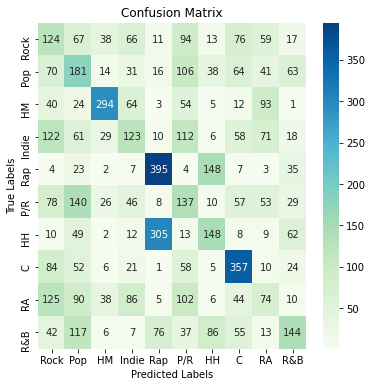

In [74]:
y_test_arg = np.argmax(y_test, axis = 1)
y_pred_1_arg = np.argmax(y_pred_1, axis = 1)

draw_cm(y_test_arg, y_pred_1_arg, 'GnBu')

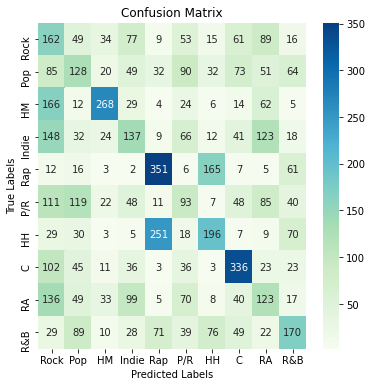

In [75]:
y_test_arg = np.argmax(y_test, axis = 1)
y_pred_2_arg = np.argmax(y_pred_2, axis = 1)

draw_cm(y_test_arg, y_pred_2_arg, 'GnBu')

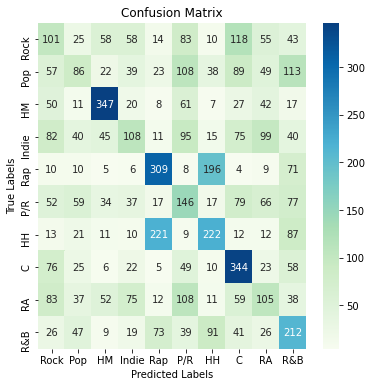

In [76]:
y_test_arg = np.argmax(y_test, axis = 1)
y_pred_3_arg = np.argmax(y_pred_3, axis = 1)

draw_cm(y_test_arg, y_pred_3_arg, 'GnBu')

In [77]:
print('Accuracy for Model 1:', accuracy_score(y_test_arg, y_pred_1_arg))

Accuracy for Model 1: 0.3295


In [78]:
print('Accuracy for Model 2:', accuracy_score(y_test_arg, y_pred_2_arg))

Accuracy for Model 2: 0.3273333333333333


In [79]:
print('Accuracy for Model 3:', accuracy_score(y_test_arg, y_pred_3_arg))

Accuracy for Model 3: 0.33
